In [216]:
# files will be taken from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
!pip install wget

In [218]:
!pip install tslearn
!pip install tensorflow

In [219]:
# import necessary packages
import wget
import math,os,csv
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from scipy import stats
import seaborn as sns

# initialize the random number generator to produce the same sequence of random numbers each time the code is executed
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

# to display an image from a file in the notebook
from IPython.display import FileLink

# to render figures in the notebook
%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.5)

In [220]:
os.chdir('/content/drive/MyDrive/Ibrahim-Gait_Prediction')

In [221]:
# '1' for Normal Gait Prediction
# '2' for Weighted Gait Prediction (knee-injury simulation)
analysis_type = 2

analysis1_files = '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Normal_Processed'
analysis2_files = '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed'

if analysis_type == 1:
  files=[os.path.join(analysis1_files,file) for file in os.listdir(analysis1_files)]
elif analysis_type == 2:
  files=[os.path.join(analysis2_files,file) for file in os.listdir(analysis2_files)]

files

['/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_1.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_3.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_2.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_6.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_7.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_4.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_9.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_dataset/Weighted_Processed/updated_vals_Weighted_8.csv',
 '/content/drive/MyDrive/Ibrahim-Gait_Prediction/updated_my_data

In [222]:
def plot_3d_array(data, cycle_length, title):
    num_cycles = round(data.shape[0] / cycle_length)
    data_reshaped = data.reshape(num_cycles, cycle_length, -1)
    mean_data = np.mean(data_reshaped, axis=0)
    plt.plot(mean_data)
    plt.title(title)
    plt.show()

def plot_mean(data, n, title):
    list_data = [data[i:i + n:] for i in range(0, data.shape[0], n)]
    #list_data = np.array_split(data, n)
    mean_data = np.mean(list_data, axis=0)
    mean_data = pd.DataFrame(mean_data)
    mean_data = mean_data.iloc[:, 0:1]
    plt.plot(mean_data)
    plt.title(title)
    plt.show()


def plot_3d_final(x,data1, data2, range_of_cycles, title):
    num_cycles = round(data1.shape[0] / range_of_cycles)
    data1_reshaped = data1.reshape(num_cycles, range_of_cycles, -1)
    data2_reshaped = data2.reshape(num_cycles, range_of_cycles, -1)
    print("Data1 reshaped shape:", data1_reshaped.shape)
    print("Data2 reshaped shape:", data2_reshaped.shape)

    mean_data1 = np.mean(data1_reshaped, axis=0)
    mean_data2 = np.mean(data2_reshaped, axis=0)

    mean_data1 = np.array(mean_data1)
    mean_data2 = np.array(mean_data2)

    mean_data1 = mean_data1.flatten()
    mean_data2 = mean_data2.flatten()

    ci = 1.96 * np.std(mean_data1)/np.sqrt(range_of_cycles)
    ci1 = 1.96 * np.std(mean_data2)/np.sqrt(range_of_cycles)

    plt.plot(x, mean_data1, color = 'lime', lw=4)  # estimated
    plt.plot(x, mean_data2, color = 'firebrick', linestyle='dashed', lw=4)  # actual
    plt.fill_between(x, (mean_data1-ci), (mean_data1+ci), color='deepskyblue', alpha=0.5) # predict confidence interval
    plt.fill_between(x, (mean_data2-ci1), (mean_data2+ci1), color='purple', alpha=0.5)  # original confidence interval
    plt.legend(['Estimated', 'Original', '95% Predict Confidence Interval', '95% Original Confidence Interval'], loc='upper right', fontsize=10)
    plt.grid()
    plt.show()

In [223]:
# create dataset for training and testing
def create_scaled_data(df):
  dataset_train = df.copy() # create copy of dataset
  cols = list(dataset_train)[1:]  # save the column (starting from the second)

  dataset_train = dataset_train[cols].astype(str)  # convert the column into string
  dataset_train = dataset_train.astype(float)  # convert the content into float
  training_set = dataset_train.values

  # Data normalization
  sc = MinMaxScaler((-4,4)) # set the min and max scale
  training_set_scaled = sc.fit_transform(training_set[:,0:1])  # transform the training set according to the scale

  sc_o = MinMaxScaler((-4,4))
  y_training_set_scaled = sc_o.fit_transform(training_set[:,1:2])

  # Create Dataset for neural network
  Xtrain = []
  ytrain = []

  n_future = 1 # Number of future values needed to be predicted / how many future numbers are to be predicted
  n_past = 20  # Number of past values required for predicting / how many past numbers need to be taken

  # Process each person separately and create input data
  for i in range(n_past, len(training_set_scaled) - n_future +1):
      Xtrain.append(training_set_scaled[i - n_past:i, :1])
      ytrain.append(y_training_set_scaled[i + n_future - 1:i + n_future, :1])

  Xtrain, ytrain = np.array(Xtrain), np.array(ytrain)

  print('X_train shape is {}.'.format(Xtrain.shape))
  print('y_train shape is {}.'.format(ytrain.shape))

  return Xtrain, ytrain, sc_o

In [224]:
X=np.array([])
y=np.array([])
X_tr = []
y_tr = []
X_ts = []
y_ts = []
n = 298

for file_path in files:
  #Read data
  df=pd.read_csv(file_path,low_memory=True,usecols = ['Time', 'Shank', 'Thigh'])
  X_tmp,y_tmp,sc_tmp=create_scaled_data(df)
  if len(y)==0:
    Xi=X_tmp
    yi=y_tmp
    X=X_tmp
    y=y_tmp
    sc=[sc_tmp]
  else:
    X=np.append(X,X_tmp,axis=0)
    y=np.append(y,y_tmp,axis=0)
    sc+=[sc_tmp]

  list_X = []
  num_chunks = round(Xi.shape[0] / n)
  for i in range(num_chunks):
      chunk = Xi[i*n:(i+1)*n,:,:]
      list_X.append(chunk)

  list_y = []
  num_chunks = round(yi.shape[0] / n)
  for i in range(num_chunks):
      chunk = yi[i*n: (i+1)*n,:,:]
      list_y.append(chunk)

  list_X = np.array(list_X)
  list_y = np.array(list_y)

  indices = list(range(num_chunks))
  random.shuffle(indices)

  # Split the data into training (80%) and testing (20%)
  tra, tes = train_test_split(indices, test_size=0.2)
  X_tr.extend([list_X[i] for i in tra])
  X_ts.extend([list_X[i] for i in tes])
  y_tr.extend([list_y[i] for i in tra])
  y_ts.extend([list_y[i] for i in tes])

X_tr = np.array(X_tr)
X_ts = np.array(X_ts)
y_tr = np.array(y_tr)
y_ts = np.array(y_ts)

X_train = []
X_test = []
y_train = []
y_test = []

for i in range(0,len(X_tr)):
  X_train.extend(X_tr[i])
X_train = np.array(X_train)
for i in range(0,len(y_tr)):
  y_train.extend(y_tr[i])
y_train = np.array(y_train)
for i in range(0,len(X_ts)):
  X_test.extend(X_ts[i])
X_test = np.array(X_test)
for i in range(0,len(y_ts)):
  y_test.extend(y_ts[i])
y_test = np.array(y_test)

print('X Test size is ' + str(X_test.shape))
print('X Train size is ' + str(X_train.shape))
print('y Test size is ' + str(y_test.shape))
print('y Train size is ' + str(y_train.shape))

X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X_train shape is (4494, 20, 1).
y_train shape is (4494, 1, 1).
X Test size is (8940, 20, 1)
X Train size is (35760, 20, 1)
y Test size is (8940, 1, 1)
y Train size is (35760, 1, 1)


In [225]:
sc[0].inverse_transform(y.reshape((y.shape[0],y.shape[-1])))
np.count_nonzero(X <-1),np.count_nonzero(X >1+1e-10),np.count_nonzero(X <0),np.count_nonzero(X >0)

stepper = (X_train.shape[0] + X_test.shape[0])//10
print(stepper)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

for i in range(0,X_train.shape[0],stepper):
  sc[int(i/stepper)].inverse_transform(y_train[i:i+stepper,:].reshape((stepper,y_train.shape[-1])))

4470
(35760, 20, 1) (35760, 1, 1) (8940, 20, 1) (8940, 1, 1)


In [226]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers import MaxPooling1D,Conv1D,Flatten,Bidirectional,GlobalMaxPooling1D,ConvLSTM1D
from keras.metrics import RootMeanSquaredError
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

def nrmse(y_true, y_pred):
    """
    Normalized Root Mean Squared Error
    Args:
        y_true ([np.array]): test samples
        y_pred ([np.array]): predicted samples
    Returns:
        [float]: normalized root mean squared error
    """
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) / K.mean(K.abs(y_true), axis=-1)

def create_model():
  model = Sequential() # linear stack of layers from Keras, used for training and evaluating the ANN
  model.add(InputLayer(input_shape=[20,1,1]))
  model.add(Conv1D(filters=128, kernel_size=1, strides=1, activation="relu"))
  model.add(Flatten()) # 3rd layer will flatten the output of previous layer into 1D tensor
  model.add(Dense(256)) # 4th layer will classify the data accordingly
  model.add(Dropout(0.3)) # 5th layer avoild overfitting
  model.add(Dense(1)) # 6th layer
  opt = keras.optimizers.Adam(learning_rate=0.001) # optimizing with specific learning rate
  model.compile(loss='mse', optimizer=opt,metrics=['mae',"accuracy",nrmse])
  model.summary() # summarize everything
  return model

In [227]:
def plot_mean_sqare_erro():
  print(history.history.keys())

  # summarize history for mean_squared_error
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model mean_squared_error')
  plt.ylabel('mean_squared_error')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(0, 14)
  plt.ylim(0, 0.3);
  plt.show()

def plot_root_mean_sqare_error():
  # summarize history for normalised_mean_squared_error
  plt.plot(history.history['nrmse'])
  plt.plot(history.history['val_nrmse'])
  plt.title('model normalised root mean squared error')
  plt.ylabel('normalised_mean_squared_error')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(0, 20)
  plt.ylim(0.5, 2.5);
  plt.show()

def plot_history_mean_square_error():
  # summarize history for mean_squared_error
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model mean_absolute_error')
  plt.ylabel('mean_absolute_error')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(0, 14)
  plt.ylim(0, 1.5);
  plt.show()

def plot_accuracy():
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Accuracy','Val accuracy'],loc='right')
  # plt.xlim(0, 14)
  # plt.ylim(0.1, 1.0);
  plt.show()

In [228]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)

# only use training dataset for cross validation - confirming data length
for train_index, test_index in kfold.split(X_train):
  print(f"Length of X train for each window:{int(len(X_train)/10)}\nLength of train index:{len(train_index)}\nLength of test index:{len(test_index)}\n\n")

Length of X train for each window:3576
Length of train index:28608
Length of test index:7152


Length of X train for each window:3576
Length of train index:28608
Length of test index:7152


Length of X train for each window:3576
Length of train index:28608
Length of test index:7152


Length of X train for each window:3576
Length of train index:28608
Length of test index:7152


Length of X train for each window:3576
Length of train index:28608
Length of test index:7152




In [229]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

train index: [ 7152  7153  7154 ... 35757 35758 35759]	test index:[   0    1    2 ... 7149 7150 7151]
X_train shape: (35760, 20, 1)
y_train shape: (35760, 1, 1)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_53 (Conv1D)          (None, 20, 1, 128)        256       
                                                                 
 flatten_53 (Flatten)        (None, 2560)              0         
                                                                 
 dense_106 (Dense)           (None, 256)               655616    
                                                                 
 dropout_53 (Dropout)        (None, 256)               0         
                                                                 
 dense_107 (Dense)           (None, 1)                 257       
                                                                 
Total params: 656129 (2.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/224 [============================>.] - ETA: 0s - loss: 0.5133 - mae: 0.5588 - accuracy: 0.0000e+00 - nrmse: 1.9839
Epoch 2: val_loss improved from 0.52953 to 0.52149, saving model to /content/weights_regression.h5
224/224 [==============================] - 9s 42ms/step - loss: 0.5134 - mae: 0.5589 - accuracy: 0.0000e+00 - nrmse: 1.9814 - val_loss: 0.5215 - val_mae: 0.5737 - val_accuracy: 0.0000e+00 - val_nrmse: 2.2834
Epoch 3/100
223/224 [============================>.] - ETA: 0s - loss: 0.4780 - mae: 0.5330 - accuracy: 0.0000e+00 - nrmse: 1.9828
Epoch 3: val_loss improved from 0.52149 to 0.50550, saving model to /content/weights_regression.h5
224/224 [==============================] - 11s 51ms/step - loss: 0.4778 - mae: 0.5328 - accuracy: 0.0000e+00 - nrmse: 1.9804 - val_loss: 0.5055 - val_mae: 0.5329 - val_accuracy: 0.0000e+00 - val_nrmse: 1.8236
Epoch 4/100
223/224 [============================>.] - ETA: 0s - loss: 0.4731 - mae: 0.5271 - accuracy: 0.0000e+00 - nrmse: 1.9702
Epoc

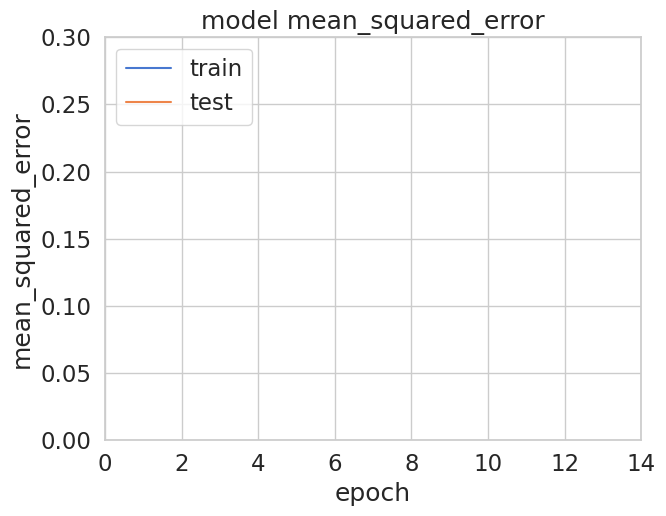

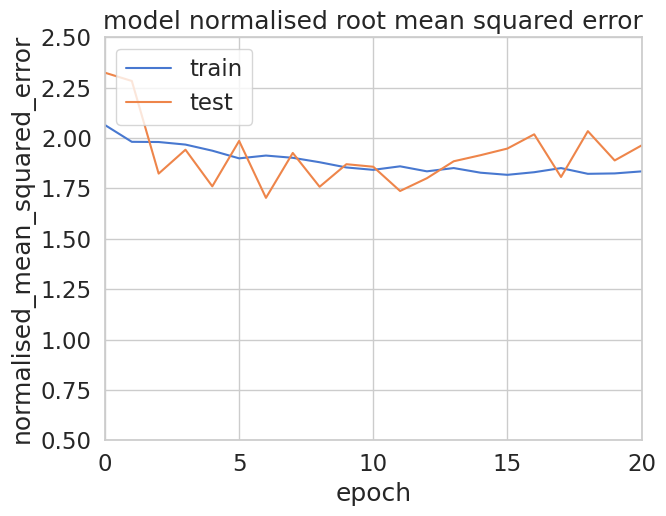

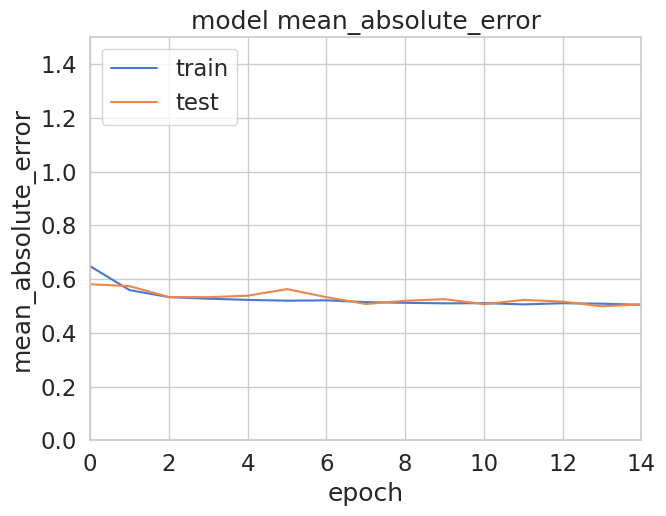

894/894 [==============================] - 3s 3ms/step
Printing training results

MAE:0.775210126490264
MSE:1.0350630865606336
RMSE:1.0173805023493587
Variance:0.7991338735008484
R2:0.7990648436917622


Printing testing results

MAE:0.7827545420370133
MSE:1.054372183172825
RMSE:1.0268262672783672
Variance:0.7973687264480791
R2:0.7973665884841523





train index: [    0     1     2 ... 35757 35758 35759]	test index:[ 7152  7153  7154 ... 14301 14302 14303]
X_train shape: (35760, 20, 1)
y_train shape: (35760, 1, 1)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 20, 1, 128)        256       
                                                                 
 flatten_54 (Flatten)        (None, 2560)              0         
                                                                 
 dense_108 (Dense)           (None, 256)               655616

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/224 [============================>.] - ETA: 0s - loss: 0.5081 - mae: 0.5549 - accuracy: 0.0000e+00 - nrmse: 2.0076
Epoch 2: val_loss improved from 0.51695 to 0.50923, saving model to /content/weights_regression.h5
224/224 [==============================] - 6s 26ms/step - loss: 0.5082 - mae: 0.5549 - accuracy: 0.0000e+00 - nrmse: 2.0049 - val_loss: 0.5092 - val_mae: 0.5709 - val_accuracy: 0.0000e+00 - val_nrmse: 2.0590
Epoch 3/100
222/224 [============================>.] - ETA: 0s - loss: 0.4830 - mae: 0.5360 - accuracy: 0.0000e+00 - nrmse: 1.9891
Epoch 3: val_loss improved from 0.50923 to 0.50390, saving model to /content/weights_regression.h5
224/224 [==============================] - 5s 22ms/step - loss: 0.4824 - mae: 0.5357 - accuracy: 0.0000e+00 - nrmse: 1.9867 - val_loss: 0.5039 - val_mae: 0.5453 - val_accuracy: 0.0000e+00 - val_nrmse: 1.5487
Epoch 4/100
223/224 [============================>.] - ETA: 0s - loss: 0.4804 - mae: 0.5321 - accuracy: 0.0000e+00 - nrmse: 1.9692
Epoch

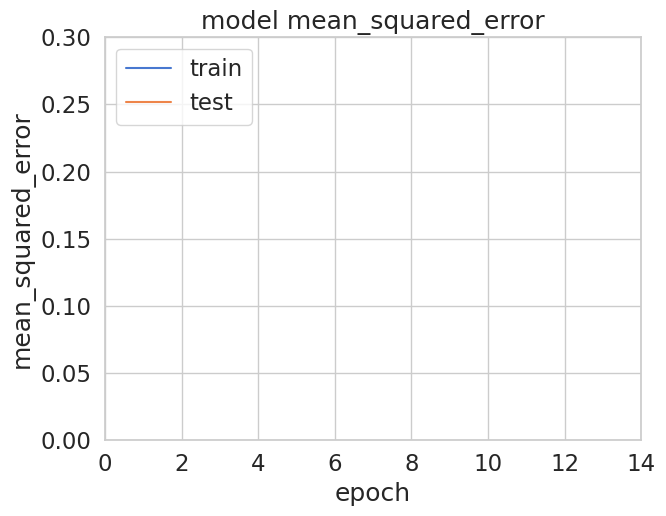

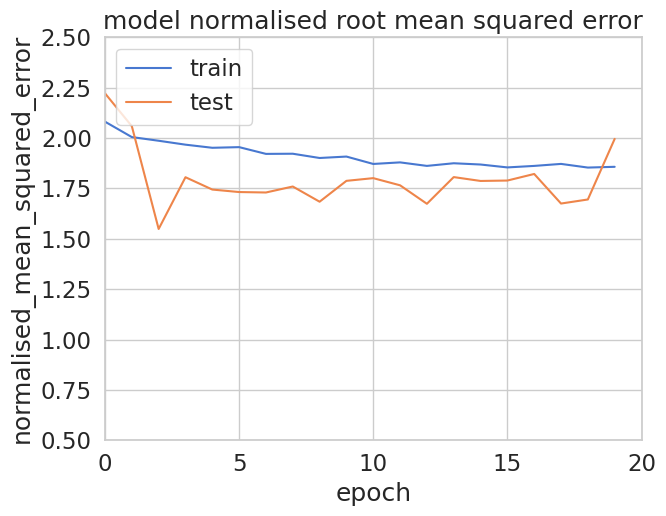

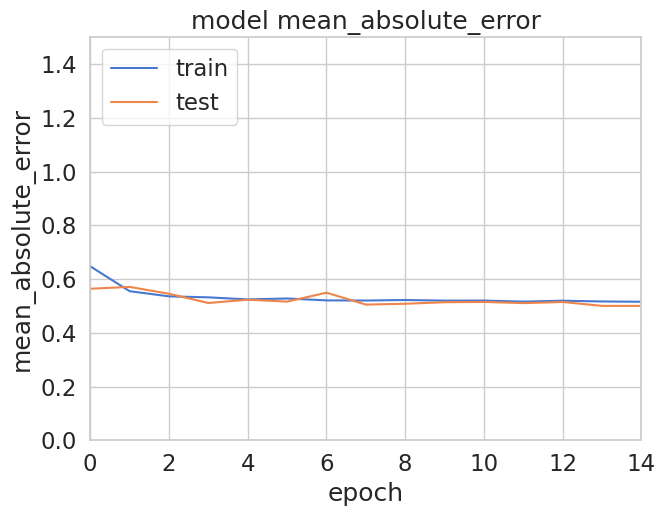

894/894 [==============================] - 3s 3ms/step
Printing training results

MAE:0.7942508553044011
MSE:1.0825443550832623
RMSE:1.0404539178085987
Variance:0.7870812012804873
R2:0.7870714966725989


Printing testing results

MAE:0.7921352970873526
MSE:1.077754790640956
RMSE:1.0381496956802307
Variance:0.7848520999699
R2:0.7848175788920405





train index: [    0     1     2 ... 35757 35758 35759]	test index:[14304 14305 14306 ... 21453 21454 21455]
X_train shape: (35760, 20, 1)
y_train shape: (35760, 1, 1)
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 20, 1, 128)        256       
                                                                 
 flatten_55 (Flatten)        (None, 2560)              0         
                                                                 
 dense_110 (Dense)           (None, 256)               655616  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/224 [============================>.] - ETA: 0s - loss: 0.5137 - mae: 0.5621 - accuracy: 0.0000e+00 - nrmse: 2.0089
Epoch 2: val_loss improved from 0.51267 to 0.49499, saving model to /content/weights_regression.h5
224/224 [==============================] - 6s 25ms/step - loss: 0.5137 - mae: 0.5620 - accuracy: 0.0000e+00 - nrmse: 2.0065 - val_loss: 0.4950 - val_mae: 0.5464 - val_accuracy: 0.0000e+00 - val_nrmse: 2.0772
Epoch 3/100
224/224 [==============================] - ETA: 0s - loss: 0.4850 - mae: 0.5380 - accuracy: 0.0000e+00 - nrmse: 1.9869
Epoch 3: val_loss did not improve from 0.49499
224/224 [==============================] - 5s 23ms/step - loss: 0.4850 - mae: 0.5380 - accuracy: 0.0000e+00 - nrmse: 1.9869 - val_loss: 0.5533 - val_mae: 0.5625 - val_accuracy: 0.0000e+00 - val_nrmse: 1.5216
Epoch 4/100
222/224 [============================>.] - ETA: 0s - loss: 0.4768 - mae: 0.5304 - accuracy: 0.0000e+00 - nrmse: 1.9582
Epoch 4: val_loss improved from 0.49499 to 0.46825, savin

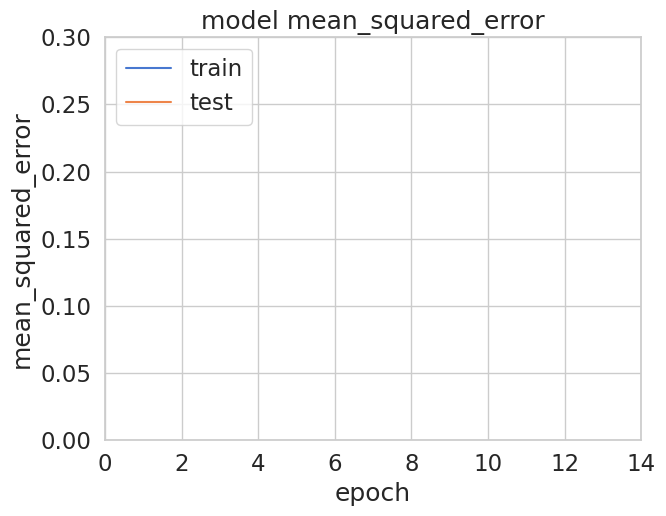

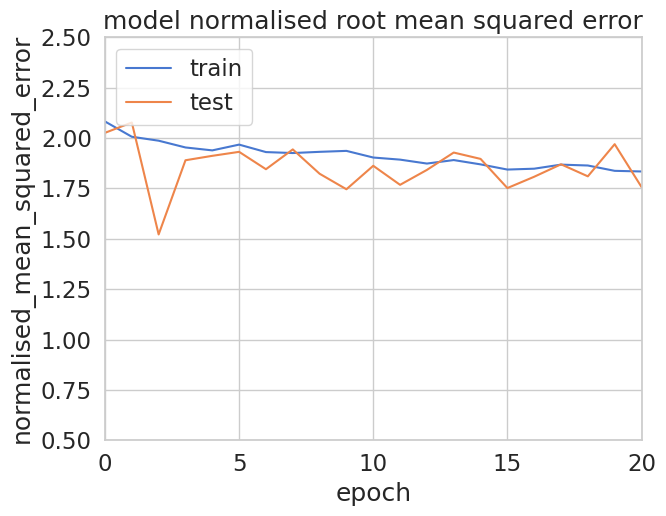

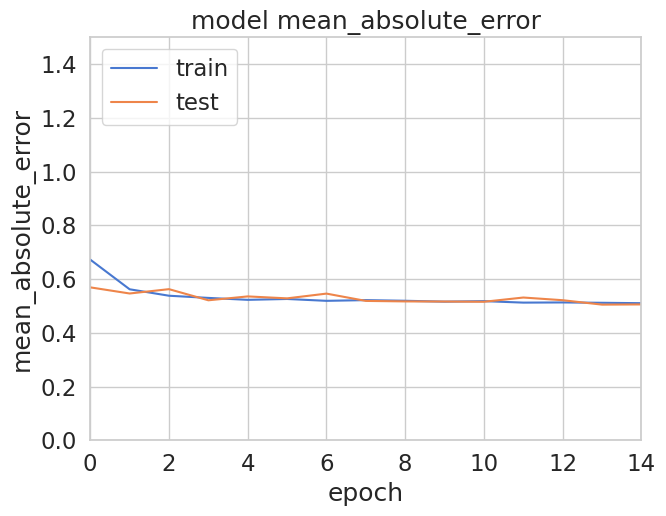

894/894 [==============================] - 3s 3ms/step
Printing training results

MAE:0.783346440494064
MSE:1.042660714869011
RMSE:1.0211075922100525
Variance:0.8033253292490385
R2:0.8029734077455124


Printing testing results

MAE:0.7935071590184439
MSE:1.0699775215452776
RMSE:1.034397177850596
Variance:0.8000248956420698
R2:0.7994050101458086





train index: [    0     1     2 ... 35757 35758 35759]	test index:[21456 21457 21458 ... 28605 28606 28607]
X_train shape: (35760, 20, 1)
y_train shape: (35760, 1, 1)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 20, 1, 128)        256       
                                                                 
 flatten_56 (Flatten)        (None, 2560)              0         
                                                                 
 dense_112 (Dense)           (None, 256)               655616 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


224/224 [==============================] - ETA: 0s - loss: 0.5184 - mae: 0.5651 - accuracy: 0.0000e+00 - nrmse: 1.9740
Epoch 2: val_loss improved from 0.50014 to 0.49439, saving model to /content/weights_regression.h5
224/224 [==============================] - 5s 24ms/step - loss: 0.5184 - mae: 0.5651 - accuracy: 0.0000e+00 - nrmse: 1.9740 - val_loss: 0.4944 - val_mae: 0.5414 - val_accuracy: 0.0000e+00 - val_nrmse: 1.7704
Epoch 3/100
224/224 [==============================] - ETA: 0s - loss: 0.4876 - mae: 0.5396 - accuracy: 0.0000e+00 - nrmse: 1.9709
Epoch 3: val_loss improved from 0.49439 to 0.47181, saving model to /content/weights_regression.h5
224/224 [==============================] - 6s 25ms/step - loss: 0.4876 - mae: 0.5396 - accuracy: 0.0000e+00 - nrmse: 1.9709 - val_loss: 0.4718 - val_mae: 0.5297 - val_accuracy: 0.0000e+00 - val_nrmse: 1.7037
Epoch 4/100
224/224 [==============================] - ETA: 0s - loss: 0.4728 - mae: 0.5304 - accuracy: 0.0000e+00 - nrmse: 1.9520
Epoch

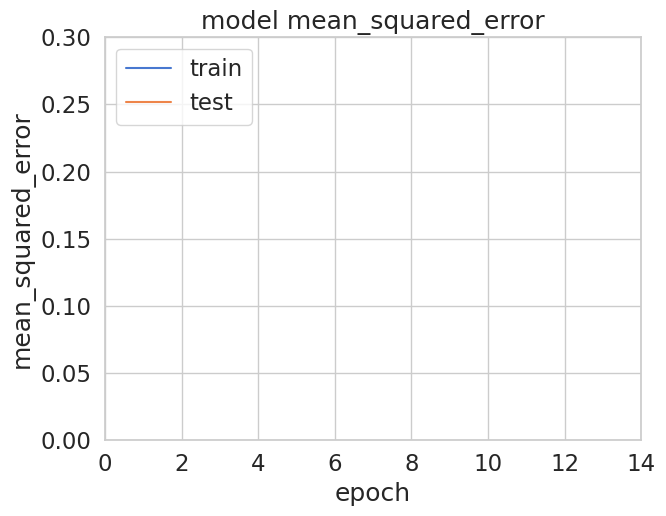

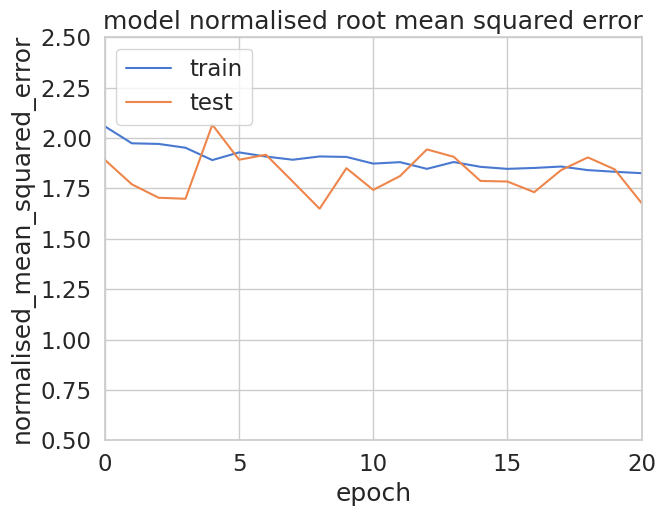

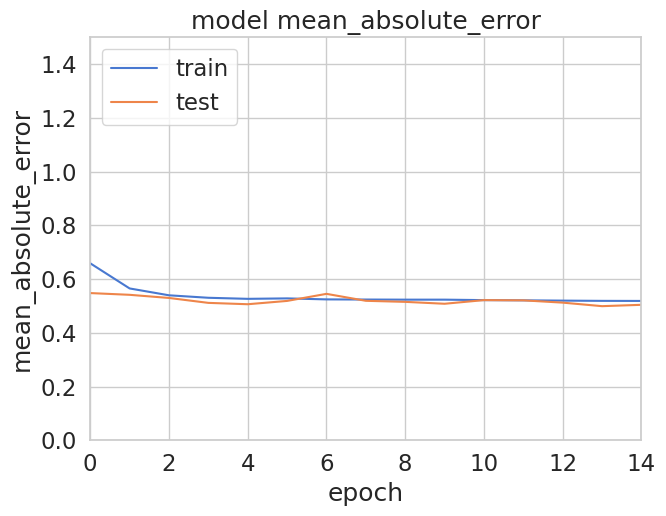

894/894 [==============================] - 3s 3ms/step
Printing training results

MAE:0.7934500854390868
MSE:1.0452042951380986
RMSE:1.0223523341481149
Variance:0.7960611264758424
R2:0.7954533195435116


Printing testing results

MAE:0.7896369636767943
MSE:1.0277487372060814
RMSE:1.0137794322267943
Variance:0.7907829782608344
R2:0.7902340401883721





train index: [    0     1     2 ... 28605 28606 28607]	test index:[28608 28609 28610 ... 35757 35758 35759]
X_train shape: (35760, 20, 1)
y_train shape: (35760, 1, 1)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 20, 1, 128)        256       
                                                                 
 flatten_57 (Flatten)        (None, 2560)              0         
                                                                 
 dense_114 (Dense)           (None, 256)               6556

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


222/224 [============================>.] - ETA: 0s - loss: 0.5002 - mae: 0.5496 - accuracy: 0.0000e+00 - nrmse: 2.0024
Epoch 2: val_loss did not improve from 0.46617
224/224 [==============================] - 5s 24ms/step - loss: 0.5003 - mae: 0.5495 - accuracy: 0.0000e+00 - nrmse: 1.9956 - val_loss: 0.4951 - val_mae: 0.5427 - val_accuracy: 0.0000e+00 - val_nrmse: 1.8814
Epoch 3/100
223/224 [============================>.] - ETA: 0s - loss: 0.4854 - mae: 0.5382 - accuracy: 0.0000e+00 - nrmse: 1.9726
Epoch 3: val_loss improved from 0.46617 to 0.44332, saving model to /content/weights_regression.h5
224/224 [==============================] - 7s 33ms/step - loss: 0.4852 - mae: 0.5382 - accuracy: 0.0000e+00 - nrmse: 1.9727 - val_loss: 0.4433 - val_mae: 0.5160 - val_accuracy: 0.0000e+00 - val_nrmse: 2.0368
Epoch 4/100
223/224 [============================>.] - ETA: 0s - loss: 0.4820 - mae: 0.5377 - accuracy: 0.0000e+00 - nrmse: 1.9458
Epoch 4: val_loss improved from 0.44332 to 0.44173, savin

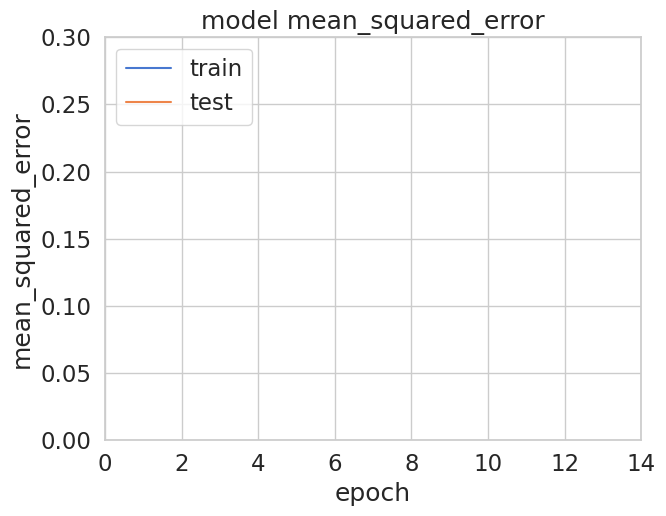

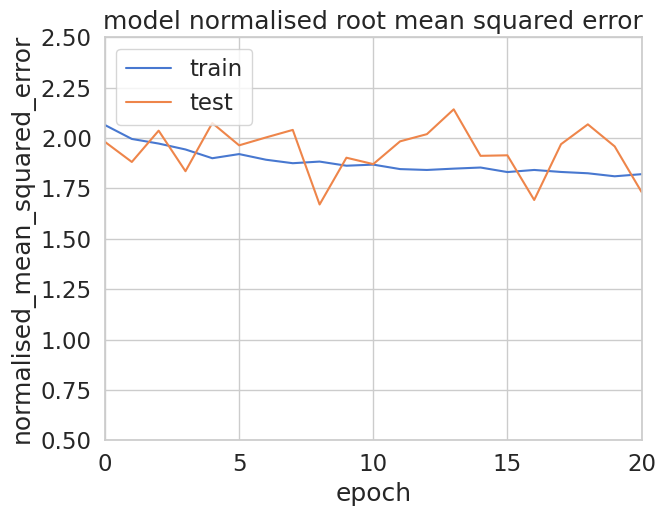

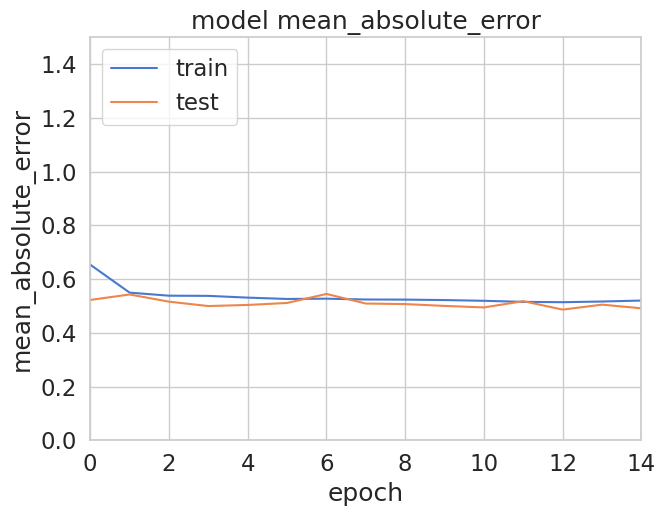

894/894 [==============================] - 8s 9ms/step
Printing training results

MAE:0.7856407966676402
MSE:1.0586812387814888
RMSE:1.0289223677136623
Variance:0.7850859666758923
R2:0.7849529548758329


Printing testing results

MAE:0.7672184974100391
MSE:1.0154916516017067
RMSE:1.0077160570327868
Variance:0.7928356183250306
R2:0.7928253193592789







In [230]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

mae_train_list = []
mse_train_list = []
rmse_train_list = []
variance_train_list = []
r2_train_list = []

mae_test_list = []
mse_test_list = []
rmse_test_list = []
variance_test_list = []
r2_teset_list = []

# only use training dataset for cross validation -> training and validation
for train_index, test_index in kfold.split(X_train):
  print(f"train index: {train_index}\ttest index:{test_index}")

  X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
  y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

  print("X_train shape:", X_train.shape)
  print("y_train shape:", y_train.shape)

  model = create_model()

  callbacks = [
      EarlyStopping(monitor='val_loss', patience=5, verbose=1),
      ModelCheckpoint('/content/weights_regression.h5', monitor='val_loss',
                      save_best_only=True, verbose=1),
  ]

  # fit the model -> fit the model into input training instances
  # epochs: no. of times for the model to go through the training dataset
  # batch size: no. of training samples process by the model at each iteration
  # verbose: control the amount of information display during training process

  # when using pca
  history = model.fit(X_train_fold, y_train_fold.reshape( (y_train_fold.shape[0],y_train_fold.shape[-1]) ), epochs=100, batch_size=128,
                    verbose=1, validation_data=(X_test_fold,y_test_fold.reshape( (y_test_fold.shape[0],y_test_fold.shape[-1]) )), use_multiprocessing=True, callbacks=callbacks)

  # when not using pca
  #history=model.fit(X_train_fold, y_train_fold.reshape( (y_train_fold.shape[0],y_train_fold.shape[-1]) ), epochs=100, batch_size=256,
  #                  verbose=1, validation_data=(X_test_fold,y_test_fold.reshape( (y_test_fold.shape[0],y_test_fold.shape[-1]) )), use_multiprocessing=True, callbacks=callbacks)

  # validation_data's definition: https://stats.stackexchange.com/questions/582805/using-x-test-y-test-as-validation-data-on-keras
  model.load_weights('/content/weights_regression.h5')

  # plotting
  plot_mean_sqare_erro()
  plot_root_mean_sqare_error()
  plot_history_mean_square_error()
  # plot_accuracy()

  # predict output (based on the whole dataset)
  test_y_predictions_fold = model.predict(X_test_fold)
  train_y_predictions_fold = model.predict(X_train_fold)
  test_y_predictions_fold = test_y_predictions_fold.reshape( (test_y_predictions_fold.shape[0],test_y_predictions_fold.shape[-1]) )
  train_y_predictions_fold = train_y_predictions_fold.reshape( (train_y_predictions_fold.shape[0],train_y_predictions_fold.shape[-1]) )

  # reshape every chunk/window
  for i in range(0,train_y_predictions_fold.shape[0],int(len(X_train)/10)):
    train_y_predictions_fold[i:i+int(len(X_train)/10),:]=sc[int(i/int(len(X_train)/10))].inverse_transform(train_y_predictions_fold[i:i+int(len(X_train)/10),:].reshape((int(len(X_train)/10),train_y_predictions_fold.shape[-1])))

  for i in range(0,test_y_predictions_fold.shape[0],int(len(X_train)/10)):
    test_y_predictions_fold[i:i+int(len(X_train)/10),:]=sc[int(i/int(len(X_train)/10))].inverse_transform(test_y_predictions_fold[i:i+int(len(X_train)/10),:].reshape((int(len(X_train)/10),test_y_predictions_fold.shape[-1])))

  # reshape
  y_test_fold=y_test_fold.reshape((y_test_fold.shape[0],y_test_fold.shape[-1]))
  y_train_fold=y_train_fold.reshape((y_train_fold.shape[0],y_train_fold.shape[-1]))

  for i in range(0,y_train_fold.shape[0],int(len(X_train)/10)):
    y_train_fold[i:i+int(len(X_train)/10),:]=sc[int(i/int(len(X_train)/10))].inverse_transform(y_train_fold[i:i+int(len(X_train)/10),:].reshape((int(len(X_train)/10),y_train_fold.shape[-1])))
  for i in range(0,y_test_fold.shape[0],int(len(X_train)/10)):
    y_test_fold[i:i+int(len(X_train)/10),:]=sc[int(i/int(len(X_train)/10))].inverse_transform(y_test_fold[i:i+int(len(X_train)/10),:].reshape((int(len(X_train)/10),y_test_fold.shape[-1])))

  pred_test_fold = test_y_predictions_fold
  pred_train_fold = train_y_predictions_fold

  # training results
  mae_train = np.round(mean_absolute_error(pred_train_fold, y_train_fold), 20)
  rmse_train = np.round(np.sqrt(mean_squared_error(pred_train_fold, y_train_fold)), 20)
  mse_train = np.round(mean_squared_error(pred_train_fold, y_train_fold), 20)
  variance_train = explained_variance_score(pred_train_fold, y_train_fold)
  r2_train = r2_score(pred_train_fold, y_train_fold)

  # testing results (for validation purposes)
  mae_test = np.round(mean_absolute_error(pred_test_fold, y_test_fold),20)
  rmse_test = np.round(np.sqrt(mean_squared_error(pred_test_fold,y_test_fold)),20)
  mse_test = np.round((mean_squared_error(pred_test_fold, y_test_fold)),20)
  variance_test = explained_variance_score(pred_test_fold, y_test_fold)
  r2_test = r2_score(pred_test_fold, y_test_fold)

  # appending
  mae_train_list.append(mae_train)
  mse_train_list.append(mse_train)
  rmse_train_list.append(rmse_train)
  variance_train_list.append(variance_train)
  r2_train_list.append(r2_train)

  mae_test_list.append(mae_test)
  mse_test_list.append(mse_test)
  rmse_test_list.append(rmse_test)
  variance_test_list.append(variance_test)
  r2_teset_list.append(r2_test)

  print("Printing training results\n")
  print(f"MAE:{mae_train}\nMSE:{mse_train}\nRMSE:{rmse_train}\nVariance:{variance_train}\nR2:{r2_train}\n\n")
  print("Printing testing results\n")
  print(f"MAE:{mae_test}\nMSE:{mse_test}\nRMSE:{rmse_test}\nVariance:{variance_test}\nR2:{r2_test}\n\n")
  print('\n\n')


In [231]:
print("Printing average (training and validation)\n")
print(f"MAE_train:{np.mean(mae_train_list)}\nMSE_train:{np.mean(mse_train_list)}\nRMSE_train:{np.mean(rmse_train_list)}\nVariance_train:{np.mean(variance_train_list)}\nR2_train:{np.mean(r2_train_list)}\n\n")
print(f"MAE_test:{np.mean(mae_test_list)}\nMSE_test:{np.mean(mse_test_list)}\nRMSE_test:{np.mean(rmse_test_list)}\nVariance_test:{np.mean(variance_test_list)}\nR2_test:{np.mean(r2_teset_list)}\n\n")

Printing average (training and validation)

MAE_train:0.7863796608790912
MSE_train:1.052830738086499
RMSE_train:1.0260433428459574
Variance_train:0.7941374994364219
R2_train:0.7939032045058436


MAE_test:0.7850504918459287
MSE_test:1.0490689768333694
RMSE_test:1.024173726013755
Variance_test:0.7931728637291828
R2_test:0.7929297074139304




# Plotting Results

In [232]:
X = np.random.rand(X_train.shape[0] + X_test.shape[0])
print(int(len(X)/10))

4470


0.007020704378193398
0.01669975352181255
0.008111515764142522
0.006997169433770459
0.006900625520673275


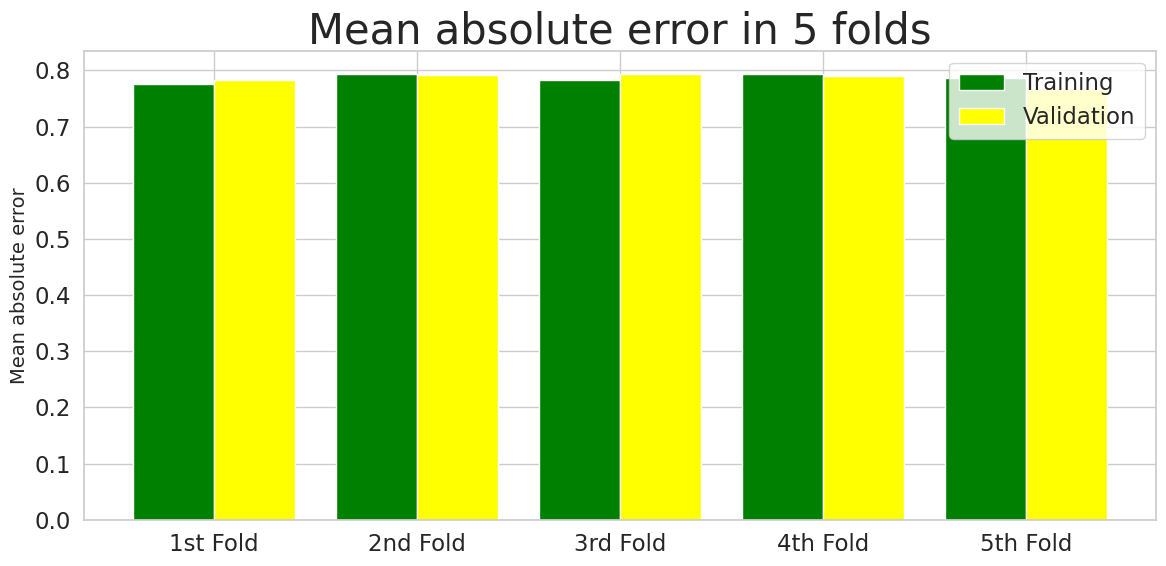

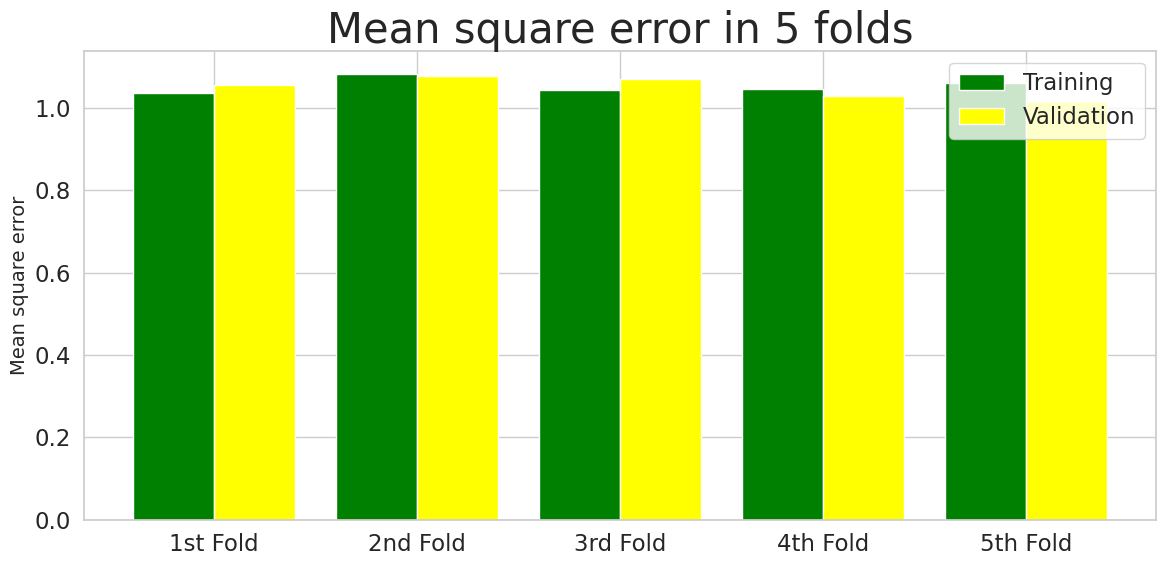

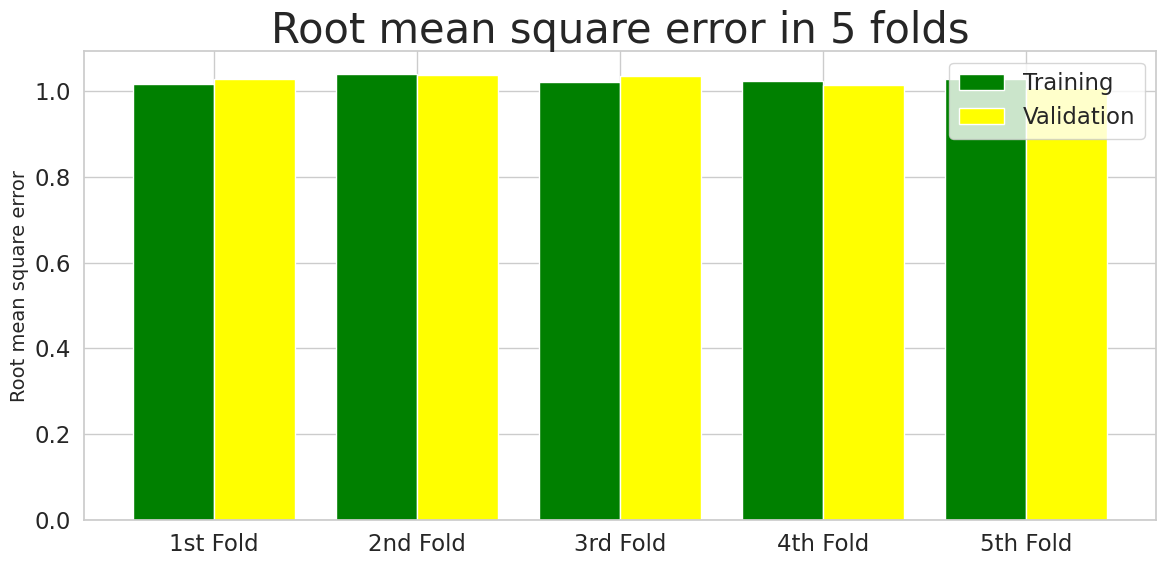

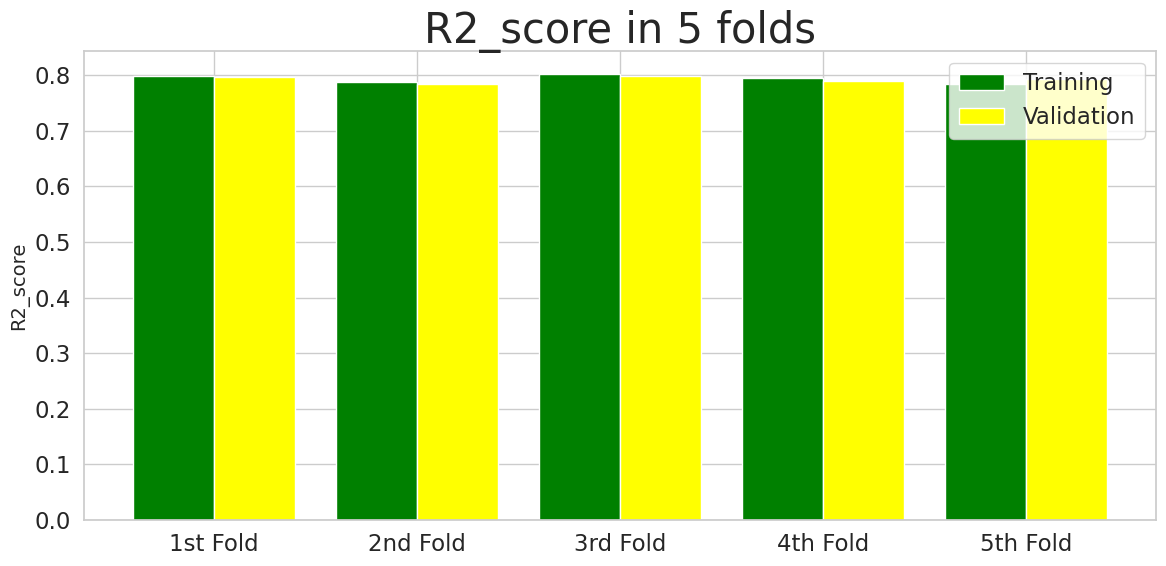

In [233]:
# Grouped Bar Chart for both training and validation data
def plot_result(y_label, plot_title, train_data, val_data):
  # Set size of plot
  plt.figure(figsize=(12,6))
  labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
  X_axis = np.arange(len(labels))
  ax = plt.gca()

  plt.bar(X_axis-0.2, train_data, 0.4, color='green', label='Training')
  plt.bar(X_axis+0.2, val_data, 0.4, color='yellow', label='Validation')
  plt.title(plot_title, fontsize=30)
  plt.xticks(X_axis, labels)
  plt.ylabel(y_label, fontsize=14)
  plt.legend()
  plt.grid(True)
  plt.show()

print(np.std(mae_train_list[0:6]))
print(np.std(mse_train_list[0:6]))
print(np.std(rmse_train_list[0:6]))
print(np.std(variance_train_list[0:6]))
print(np.std(r2_train_list[0:6]))

plot_result("Mean absolute error", "Mean absolute error in 5 folds", mae_train_list, mae_test_list)
plot_result("Mean square error", "Mean square error in 5 folds", mse_train_list, mse_test_list)
plot_result("Root mean square error", "Root mean square error in 5 folds", rmse_train_list, rmse_test_list)
# plot_result("Variance", "Variance in 5 folds", variance_train_list, variance_test_list)
plot_result("R2_score", "R2_score in 5 folds", r2_train_list, r2_teset_list)
# plot_result("Pearson Correlation", "Pearson Correlation in 5 folds", corr_train, corr_test)

In [234]:
test_y_predictions = model.predict(X_test)
train_y_predictions = model.predict(X_train)
test_y_predictions = test_y_predictions.reshape( (test_y_predictions.shape[0],test_y_predictions.shape[-1]) )
train_y_predictions = train_y_predictions.reshape( (train_y_predictions.shape[0],train_y_predictions.shape[-1]) )

print(train_y_predictions.shape, test_y_predictions.shape)
print(X.shape, y.shape)

for i in range(0,train_y_predictions.shape[0],int(len(X)/10)):
  train_y_predictions[i:i+int(len(X)/10),:]=sc[int(i/int(len(X)/10))].inverse_transform(train_y_predictions[i:i+int(len(X)/10),:].reshape((int(len(X)/10),train_y_predictions.shape[-1])))

for i in range(0,test_y_predictions.shape[0],int(len(X)/10)):
  test_y_predictions[i:i+int(len(X)/10),:]=sc[int(i/int(len(X)/10))].inverse_transform(test_y_predictions[i:i+int(len(X)/10),:].reshape((int(len(X)/10),test_y_predictions.shape[-1])))


y_test=y_test.reshape((y_test.shape[0],y_test.shape[-1]))
y_train=y_train.reshape((y_train.shape[0],y_train.shape[-1]))

for i in range(0,y_train.shape[0],int(len(X)/10)):
  y_train[i:i+int(len(X)/10),:]=sc[int(i/int(len(X)/10))].inverse_transform(y_train[i:i+int(len(X)/10),:].reshape((int(len(X)/10),y_train.shape[-1])))

for i in range(0,y_test.shape[0],int(len(X)/10)):
  y_test[i:i+int(len(X)/10),:]=sc[int(i/int(len(X)/10))].inverse_transform(y_test[i:i+int(len(X)/10),:].reshape((int(len(X)/10),y_test.shape[-1])))

1118/1118 [==============================] - 3s 3ms/step
(35760, 1) (8940, 1)
(44700,) (44940, 1, 1)


In [235]:
pred_test = test_y_predictions
pred_train = train_y_predictions

# training results
mae_train = np.round(mean_absolute_error(pred_train, y_train), 20)
rmse_train = np.round(np.sqrt(mean_squared_error(pred_train, y_train)), 20)
mse_train = np.round(mean_squared_error(pred_train, y_train), 20)
variance_train = explained_variance_score(pred_train, y_train)
r2_train = r2_score(pred_train, y_train)

# testing results
mae_test = np.round(mean_absolute_error(pred_test, y_test),20)
rmse_test = np.round(np.sqrt(mean_squared_error(pred_test, y_test)),20)
mse_test = np.round((mean_squared_error(pred_test, y_test)),20)
variance_test = explained_variance_score(pred_test, y_test)
r2_test = r2_score(pred_test, y_test)

# appending
mae_train_list.append(mae_train)
mse_train_list.append(mse_train)
rmse_train_list.append(rmse_train)
variance_train_list.append(variance_train)
r2_train_list.append(r2_train)

mae_test_list.append(mae_test)
mse_test_list.append(mse_test)
rmse_test_list.append(rmse_test)
variance_test_list.append(variance_test)
r2_teset_list.append(r2_test)

print("Printing training results\n")
print(f"MAE:{mae_train}\nMSE:{mse_train}\nRMSE:{rmse_train}\nVariance:{variance_train}\nR2:{r2_train}\n\n")
print("Printing testing results\n")
print(f"MAE:{mae_test}\nMSE:{mse_test}\nRMSE:{rmse_test}\nVariance:{variance_test}\nR2:{r2_test}\n\n")
print('\n\n')

Printing training results

MAE:0.7830908062034575
MSE:1.0538276349129105
RMSE:1.0265610721788112
Variance:0.7865983567393188
R2:0.7864997386084405


Printing testing results

MAE:0.7616368882615393
MSE:0.9915006000365862
RMSE:0.9957412314635699
Variance:0.787668019109397
R2:0.7876316340372854







In [236]:
from scipy.stats import pearsonr

#reshape the arrays to 1-D
pred_trainPC = pred_train.flatten()
y_trainPC = y_train.flatten()

pred_testPC = pred_test.flatten()
y_testPC = y_test.flatten()

# calculate pearson correlation coefficient for training data
corr_train,_ = pearsonr(pred_trainPC, y_trainPC)

# calculate pearson correlation coefficient for testing data
corr_test,_ = pearsonr(pred_testPC, y_testPC)

# results
print("Pearson Correlation (Training): " + str(corr_train))
print("Pearson Correlation (Testing): " + str(corr_test))

Pearson Correlation (Training): 0.9093671893846287
Pearson Correlation (Testing): 0.9110906491750977


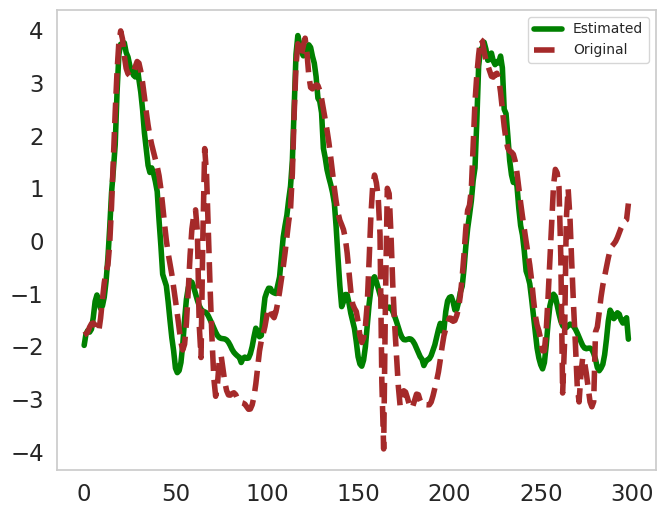

In [237]:
Predy_thigh = pred_test[:,0]
ytest_thigh = y_test[:,0]

Predy_thigh1 = Predy_thigh.reshape(-1, 1)
ytest_thigh1 = ytest_thigh.reshape(-1, 1)

sc_new = MinMaxScaler((-4,4))
Predy_thigh_scaled = sc_new.fit_transform(Predy_thigh1)

sc_o_new = MinMaxScaler((-4,4))
ytest_thigh_scaled = sc_o_new.fit_transform(ytest_thigh1)

plt.rcParams["figure.figsize"] = [7.0, 5.50]
plt.rcParams["figure.autolayout"] = True

Predy_thigh_final = Predy_thigh
ytest_thigh_final = ytest_thigh

cycles = 3

range_of_cycles = (cycles*100)-1
x = np.arange(0, range_of_cycles, 1)
y = np.array(Predy_thigh_final[0:len(x)])
y = y.flatten()
y1 = np.array(ytest_thigh_final[0:len(x)])
y1 = y1.flatten()

# Define the confidence interval
# ci = 1.96 * np.std(y)/np.sqrt(len(x))
# ci1 = 1.96 * np.std(y1)/np.sqrt(len(x))

plt.plot(x, y, color = 'green', lw=4) # estimated
plt.plot(x, y1, color = 'brown', linestyle='dashed', lw=4) # actual
# plt.fill_between(x, (y-ci), (y+ci), color='deepskyblue', alpha=0.5) # predict confidence interval
# plt.fill_between(x, (y1-ci1), (y1+ci1), color='purple', alpha=0.5) # original confidence interval
plt.legend(['Estimated', 'Original', '95% Predict Confidence Interval', '95% Original Confidence Interval'], loc='upper right', fontsize=10)
plt.grid()
plt.show()
plt.rcParams["figure.figsize"] = [7.0, 5.50]

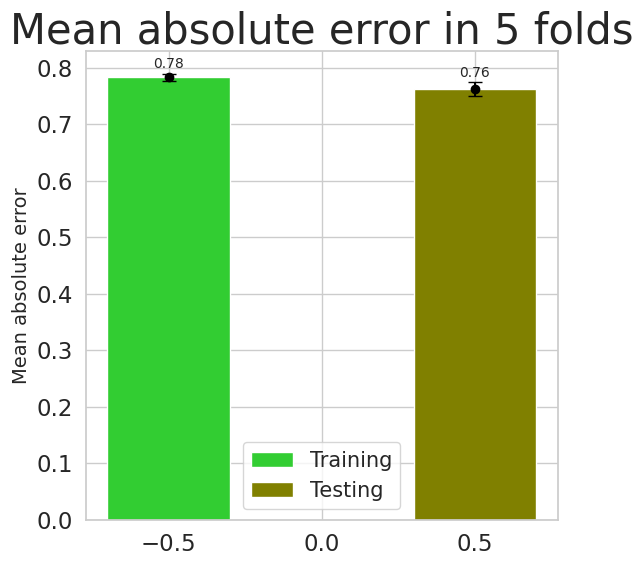

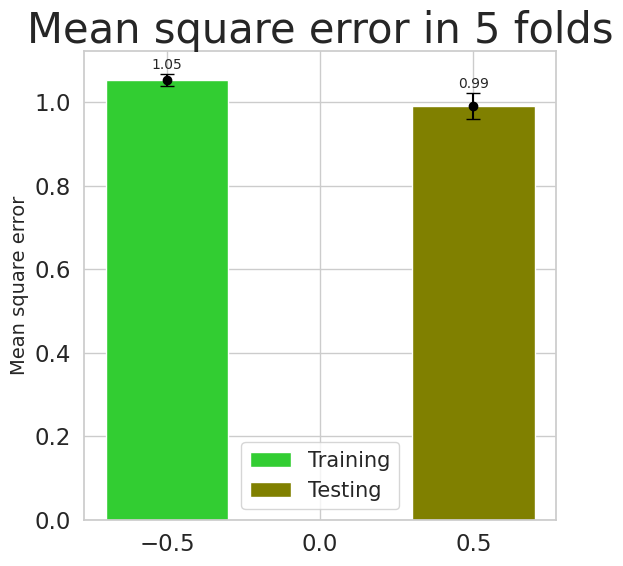

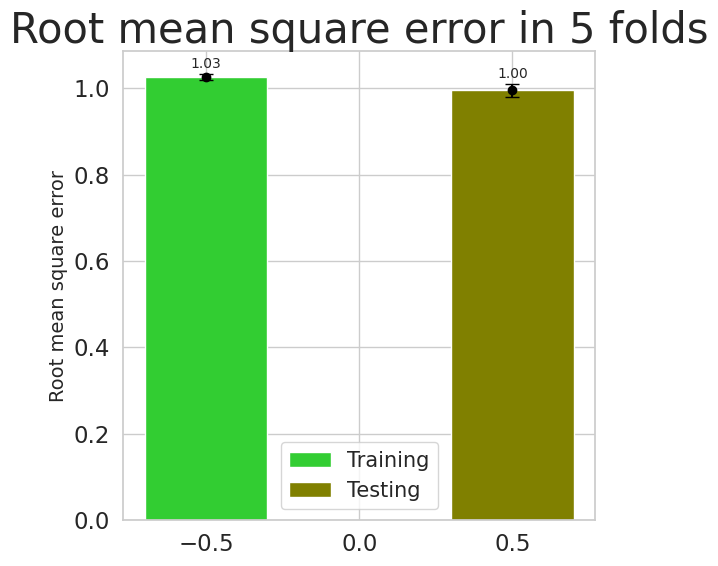

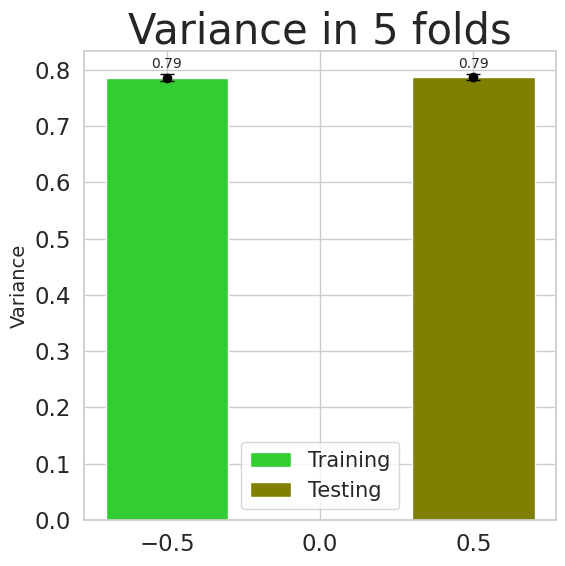

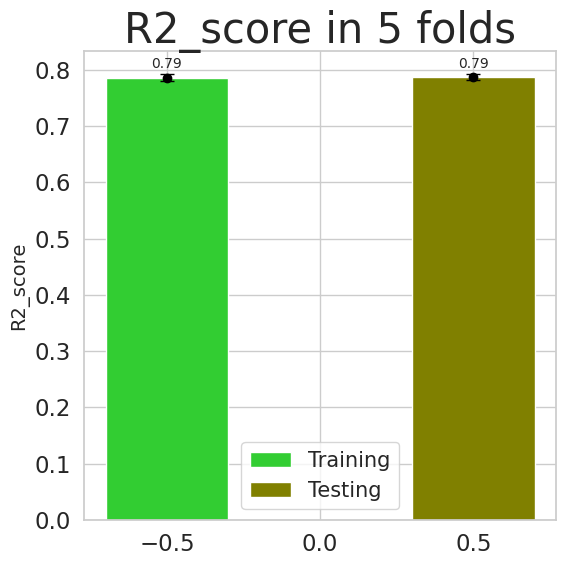

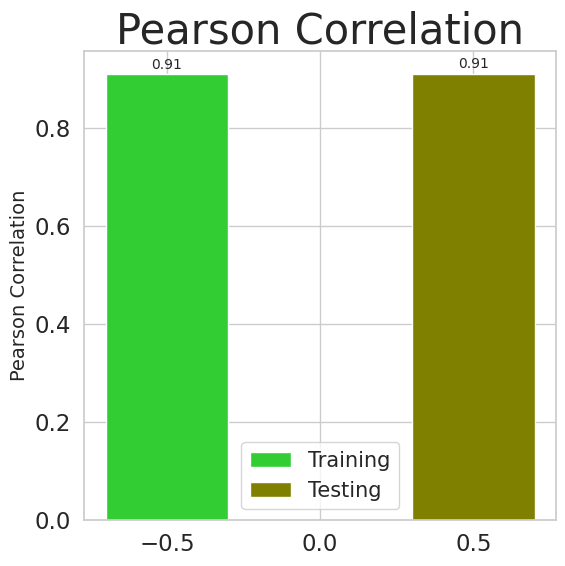

In [238]:
# Grouped Bar Chart for both training and validation data
def plot_testing_result(y_label, plot_title, train_data, train_std, val_data, val_std):
    # Set size of plot
    plt.figure(figsize=(6, 6))
    fz = 10

    # X-axis positions for the bars
    X_axis = np.arange(1)

    # Plot the training data with error bars
    plt.bar(X_axis - 0.5, train_data, 0.4, color='limegreen', label='Training')

    if train_std != 0:
      plt.errorbar(X_axis - 0.5, train_data, yerr=train_std, fmt='o', color='black', capsize=5)
    plt.text(X_axis - 0.5, train_data + train_std + 0.005, f"{train_data:.2f}", ha='center', va='bottom', fontsize=fz)

    # Plot the testing data with error bars
    plt.bar(X_axis + 0.5, val_data, 0.4, color='olive', label='Testing')

    if val_std != 0:
      plt.errorbar(X_axis + 0.5, val_data, yerr=val_std, fmt='o', color='black', capsize=5)
    plt.text(X_axis + 0.5, val_data + val_std + 0.005, f"{val_data:.2f}", ha='center', va='bottom', fontsize=fz)

    plt.title(plot_title, fontsize=30)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=fz+5)
    plt.grid(True)
    plt.show()

mae_train_std = np.std(mae_train_list)
mse_train_std = np.std(mse_train_list)
rmse_train_std = np.std(rmse_train_list)
variance_train_std = np.std(variance_train_list)
r2_train_std = np.std(r2_train_list)

mae_test_std = np.std(mae_test_list)
mse_test_std = np.std(mse_test_list)
rmse_test_std = np.std(rmse_test_list)
variance_test_std = np.std(variance_test_list)
r2_teset_std = np.std(r2_teset_list)

plot_testing_result("Mean absolute error", "Mean absolute error in 5 folds", mae_train, mae_train_std, mae_test, mae_test_std)
plot_testing_result("Mean square error", "Mean square error in 5 folds", mse_train, mse_train_std, mse_test, mse_test_std)
plot_testing_result("Root mean square error", "Root mean square error in 5 folds", rmse_train, rmse_train_std, rmse_test, rmse_test_std)
plot_testing_result("Variance", "Variance in 5 folds", variance_train, variance_train_std, variance_test, variance_test_std)
plot_testing_result("R2_score", "R2_score in 5 folds", r2_train, r2_train_std, r2_test, r2_teset_std)

plot_testing_result("Pearson Correlation", "Pearson Correlation", corr_train, 0, corr_test, 0)